# Load

In [1]:
import pandas as pd
import numpy as np

gold = pd.read_csv(r"data/annual_gold_rate.csv")
display(gold.head())

,Date,USD,EUR,GBP,INR,AED,CNY
0,1978,193.44,124.73580,100.65449,NaN,NaN,NaN
1,1979,304.68,185.06142,143.09014,2481.90512,1163.93597,NaN
2,1980,614.50,378.19461,263.80259,4831.74943,2278.36795,NaN
3,1981,459.26,360.90588,227.01948,3966.64790,1691.03194,NaN
4,1982,375.30,345.59742,215.53232,3553.62680,1378.72895,NaN


# Clean

We're only interested in the USD gold prices, so we'll drop the other currency columns.

In [2]:
gold = gold[["Date", "USD"]]

gold.index = gold["Date"]
gold = gold.drop(columns=["Date"])
gold.index = pd.to_datetime(gold.index, format="%Y")
gold.index.freq = gold.index.inferred_freq

# EDA

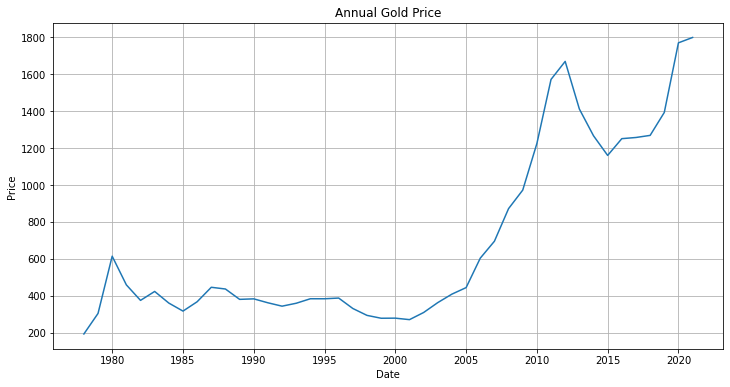

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(gold.index, gold["USD"])
plt.title("Annual Gold Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid()
plt.show()

## Decomposition/Anomaly Detection

We'll use STL Decomposition to look for anomalies in the data.

In [4]:
from statsmodels.tsa.seasonal import STL

stl = STL(gold["USD"], robust=True, period=12)
res = stl.fit()

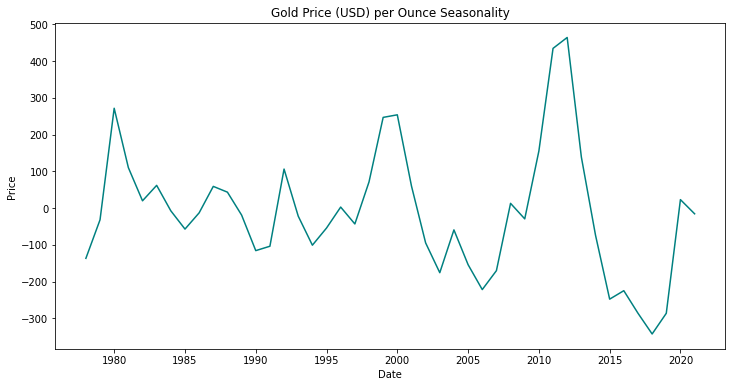

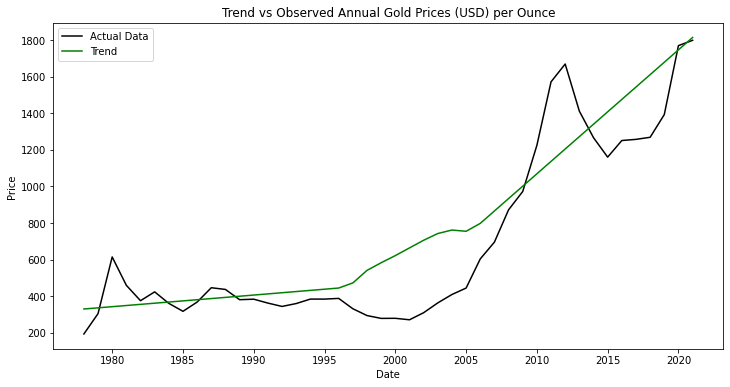

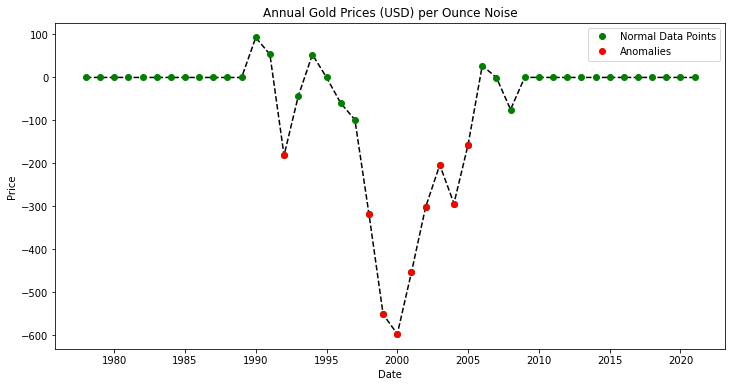

In [5]:
#seasonality
season_x = res.seasonal.index
season_y = res.seasonal.values
plt.figure(figsize=(12,6))
plt.title("Gold Price (USD) per Ounce Seasonality")
plt.plot(season_x, season_y, c="teal")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


#trend
trend_x = res.trend.index
trend_y = res.trend.values

#plot actual vs. trend
plt.figure(figsize=(12,6))
plt.title("Trend vs Observed Annual Gold Prices (USD) per Ounce")
plt.plot(gold["USD"], c="black", label="Actual Data")
plt.plot(trend_x, trend_y, c="g", label="Trend")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

#residual
res_x = res.resid.index
res_y = res.resid.values

#plot residual
plt.figure(figsize=(12,6))
plt.title("Annual Gold Prices (USD) per Ounce Noise")
plt.plot(res_x, res_y, ls="--", c='black')
plt.plot_date(res_x, res_y, color='g', label="Normal Data Points")

low_outlier_index = np.where(res.resid.values <= -150)
plt.plot_date(res_x[low_outlier_index], res_y[low_outlier_index], c="red")
high_outlier_index = np.where(res.resid.values >= 150)
plt.plot_date(res_x[high_outlier_index], res_y[high_outlier_index], c="red", label="Anomalies")

plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Model

For the model,  we'll use Holt' Linear Trend Method (Double Exponential Smoothing) since the data appears to have high variation.

In [17]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

train = gold.iloc[:31]
test = gold.iloc[31:]

holts = ExponentialSmoothing(train, trend="mul")
holts_fit = holts.fit(optimized=True)
train_pred = holts_fit.predict(start=0)
test_pred = holts_fit.forecast((len(gold)-len(train)))

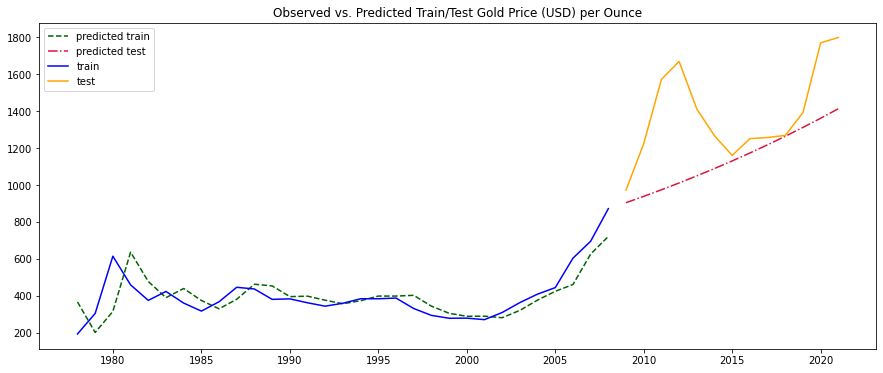

Scatter Index: 0.23422323150774105


In [22]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#observed vs predicted
plt.figure(figsize=(15,6))
plt.plot(train_pred, color="darkgreen", label="predicted train", ls="--")
plt.plot(test_pred, color="crimson", label="predicted test", ls="-.")
plt.plot(train, color="blue", label="train")
plt.plot(test, color="orange", label="test")
plt.title("Observed vs. Predicted Train/Test Gold Price (USD) per Ounce")
plt.legend()
plt.show()

mse = mean_squared_error(test, test_pred)
scatter_index = (sqrt(mse))/(test.mean())[0].round(3)
print("Scatter Index:", scatter_index)

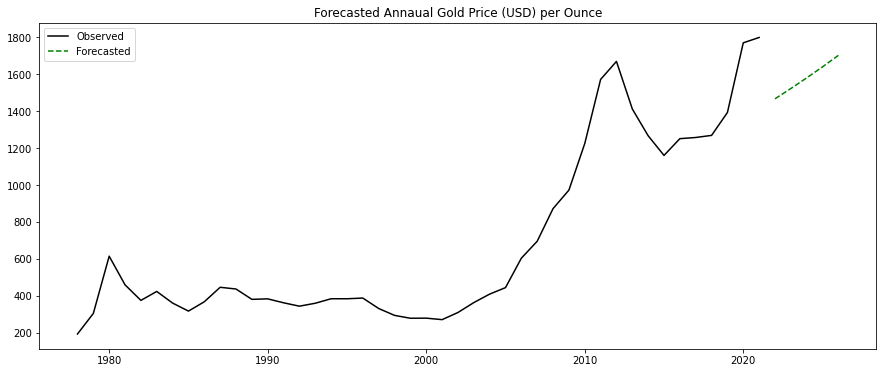

2022-01-01    1466.550114
2023-01-01    1522.131953
2024-01-01    1579.820328
2025-01-01    1639.695076
2026-01-01    1701.839061
Freq: AS-JAN, dtype: float64


In [19]:
#forecast
forecast = holts_fit.forecast((len(gold)-len(train))+5)
plt.figure(figsize=(15,6))
plt.plot(gold.index, gold["USD"], color="black", label="Observed")
plt.plot(forecast[(len(gold)-len(train)):], color="green", ls="--", label="Forecasted")
plt.title("Forecasted Annaual Gold Price (USD) per Ounce")
plt.legend()
plt.show()

print(forecast[(len(gold)-len(train)):])